In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

In [16]:
# Check to see if a GPU is available. This should show your RTX 3050.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# This is a good practice to prevent TensorFlow from allocating all of the GPU memory at once.
# This makes it easier to run multiple processes on the same GPU if needed.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # We'll set the memory growth to True
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # The code below will tell you which physical devices TensorFlow is using
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [17]:
# IMPORTANT: Update this with the path to your main dataset folder
dataset_path = 'New Plant Diseases Dataset/'
train_dir = os.path.join(dataset_path, 'train')
valid_dir = os.path.join(dataset_path, 'valid')
test_dir = os.path.join(dataset_path, 'test')

# Set up some parameters for our images
image_size = (256, 256) # We'll resize all images to this size
batch_size = 16 # This is how many images we'll load at a time

# This is the generator for our training data. It will apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # This normalizes the pixel values to be between 0 and 1
    rotation_range=40, # Randomly rotate images
    width_shift_range=0.2, # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2, # Apply a shearing transformation
    zoom_range=0.2, # Randomly zoom into images
    horizontal_flip=True, # Randomly flip images horizontally
)

# This is the generator for our validation data. We don't augment this one!
# We just need to rescale it to match the training data
valid_datagen = ImageDataGenerator(rescale=1./255)

# This is the generator for our test data. We also don't augment this one.
test_datagen = ImageDataGenerator(rescale=1./255)


# Now, we link the generators to our dataset folder structure
# This is where the magic happens and it automatically finds the classes from the folder names
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical', # Because we have multiple classes (plant types, diseases)
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

# Let's get the number of classes, we'll need this for our model
num_classes = train_generator.num_classes
print(f"\nNumber of classes found: {num_classes}")

# A quick check to make sure it's working and to see our classes
print(f"Number of training images: {train_generator.samples}")
print(f"Number of validation images: {validation_generator.samples}")
print(f"Number of test images: {test_generator.samples}")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.

Number of classes found: 38
Number of training images: 70295
Number of validation images: 17572
Number of test images: 33


In [18]:
# First, let's get the number of classes from our data generator
num_classes = train_generator.num_classes

# Load the MobileNetV2 base model, pre-trained on ImageNet
# We'll set 'include_top=False' to remove the original classification layers
base_model = MobileNetV2(
    input_shape=(256, 256, 3), # This must match the image size we set up earlier
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers so they don't get retrained
# We want to use its knowledge, not change it
base_model.trainable = False

# Now, we'll build our new classification head on top of the base model
# This is where our model will learn to classify our 38 unique classes
x = base_model.output
x = GlobalAveragePooling2D()(x) # This flattens the features for our dense layers
x = Dense(1024, activation='relu')(x) # A new dense layer to learn complex patterns
predictions = Dense(num_classes, activation='softmax')(x) # Our final output layer

# Combine the base model and our new layers into a complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Now, we compile the model
# We'll use the Adam optimizer, which is a great choice for most tasks
# 'categorical_crossentropy' is the standard loss function for multi-class problems
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Let's print a summary of our model to see the architecture
model.summary()

/tmp/ipykernel_128245/1349554554.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 3,608,678 (13.77 MB)

 Trainable params: 1,350,694 (5.15 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
# # Create a folder to save our trained model
# model_save_path = "plant_disease_model"
# os.makedirs(model_save_path, exist_ok=True)

# # Set up the callbacks
# # This will save the best version of our model based on validation accuracy
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     os.path.join(model_save_path, 'best_model.keras'),
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )

# # This will stop training if the validation accuracy doesn't improve for 3 epochs
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=3,
#     mode='max',
#     restore_best_weights=True,
#     verbose=1
# )

# # Now, we train the model!
# # We'll start with just 10 epochs. You can increase this later if needed.
# history = model.fit(
#     train_generator,
#     epochs=15,
#     validation_data=validation_generator,
#     callbacks=[checkpoint, early_stopping]
# )

# # Save the entire trained model for later use, including its optimizer state and everything else
# model.save(os.path.join(model_save_path, 'final_model.keras'))

In [20]:
# # Plotting the training and validation accuracy
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plotting the training and validation loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [21]:
# # It's a good practice to load the best model for a final evaluation
# # The EarlyStopping callback has already restored the best weights, but let's be explicit
# best_model = tf.keras.models.load_model(os.path.join(model_save_path, 'best_model.keras'))

# # Now, we evaluate the best model on the validation data.
# # We'll use this as our final, unbiased test set since your original test set was too small.
# print("\nEvaluating the best model on the validation set...")
# loss, accuracy = best_model.evaluate(validation_generator)
# print(f"Final Validation Loss: {loss:.4f}")
# print(f"Final Validation Accuracy: {accuracy:.4f}")

I0000 00:00:1755272850.572653  131874 service.cc:152] XLA service 0x791600014110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755272850.572674  131874 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-15 21:17:30.605292: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755272851.219944  131874 cuda_dnn.cc:529] Loaded cuDNN version 91200
2025-08-15 21:17:39.531952: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-15 21:17:39.656226: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup e

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


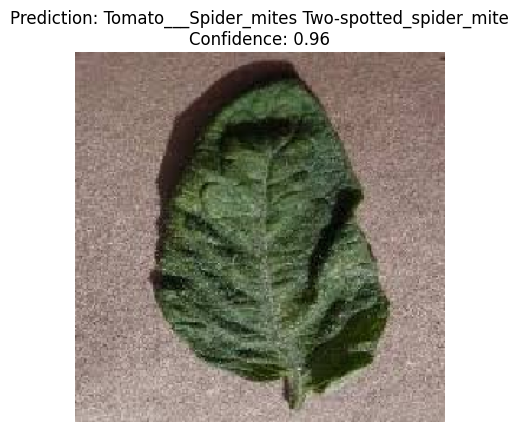

In [22]:
# Load the best model we saved earlier
best_model = load_model('plant_disease_model/best_model.keras')

# --- IMPORTANT: UPDATE THIS PART ---
# You need a way to get the class names from the training data.
# The `train_generator` you created earlier holds this information.
# You can run `print(train_generator.class_indices)` in a previous cell
# to get the dictionary, then copy/paste the sorted keys here.
class_names = sorted(list(train_generator.class_indices.keys()))
# Alternatively, if you don't have the generator in memory,
# you can get them from your dataset folder structure
# class_names = sorted(os.listdir('New Plant Diseases Dataset/train'))


# Path to the image you want to test
image_path = 'image copy 5.png'

# --- Function to load and preprocess the image ---
def preprocess_image(img_path):
    # Load the image and resize it to our model's input size
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    # The model expects a batch of images, so we add a new dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the pixel values just like we did with our training data
    img_array = img_array / 255.0
    return img_array, img

# --- Make a prediction ---
# Preprocess the image
img_array, original_img = preprocess_image(image_path)
# Get the model's prediction
predictions = best_model.predict(img_array)
# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions[0])
# Get the name of the predicted class
predicted_class_name = class_names[predicted_class_index]
# Get the confidence score
confidence = predictions[0][predicted_class_index]

# --- Display the results ---
plt.imshow(original_img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}\nConfidence: {confidence:.2f}")
plt.show()

In [23]:
# First, let's load our best-performing model
best_model = tf.keras.models.load_model('plant_disease_model/best_model.keras')

# Now, we'll unfreeze the entire base model.
# Note: we need to use 'base_model.trainable = True' and not 'model.trainable = True'
best_model.trainable = True

# We'll use a much lower learning rate for this step
# This ensures that the model doesn't drastically change its weights
best_model.compile(optimizer=Adam(learning_rate=1e-5),  # A very small learning rate
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Let's see the summary again to confirm all layers are now trainable
best_model.summary()

# Now, we'll continue training for a few more epochs
# Let's use the same callbacks to save the new best model and prevent overfitting
# This will be saved to a new path to prevent overwriting
fine_tuned_model_save_path = "fine_tuned_model"
os.makedirs(fine_tuned_model_save_path, exist_ok=True)

fine_tune_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(fine_tuned_model_save_path, 'best_fine_tuned_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# We'll still use the early stopping callback
fine_tune_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    mode='max',
    restore_best_weights=True,
    verbose=1
)


print("\nStarting to fine-tune the model...")
fine_tune_history = best_model.fit(
    train_generator,
    epochs=10, # We'll start with 10 more epochs, let early stopping handle the rest
    validation_data=validation_generator,
    callbacks=[fine_tune_checkpoint, fine_tune_early_stopping]
)

# Save the final fine-tuned model
best_model.save(os.path.join(fine_tuned_model_save_path, 'final_fine_tuned_model.keras'))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 3,608,678 (13.77 MB)

 Trainable params: 1,350,694 (5.15 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting to fine-tune the model...


/home/harishankar/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-08-15 21:17:50.700681: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1406_0', 200 bytes spill stores, 536 bytes spill loads

2025-08-15 21:17:50.839144: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1406', 4 bytes spill stores, 4 bytes spill loads

2025-08-15 21:17:50.938937: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1406', 116 bytes spill stores, 116 bytes spill loads

2025-08-15 21:17:52.026696: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1406', 5356 bytes spill stores, 5416 bytes spill loads

2025-08-15 21:17:52.044722: I ex

1199/4394 ━━━━━━━━━━━━━━━━━━━━ 8:27 159ms/step - accuracy: 0.9516 - loss: 0.1506

2025-08-15 21:21:20.545744: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1406', 12 bytes spill stores, 12 bytes spill loads

2025-08-15 21:21:21.045763: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1406', 8 bytes spill stores, 8 bytes spill loads

2025-08-15 21:21:21.059056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1406', 112 bytes spill stores, 112 bytes spill loads

2025-08-15 21:21:21.893098: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1406_0', 184 bytes spill stores, 520 bytes spill loads

2025-08-15 21:21:22.717953: I extern

4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9535 - loss: 0.1452

2025-08-15 21:30:06.337610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195_0', 184 bytes spill stores, 520 bytes spill loads

2025-08-15 21:30:06.399911: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 112 bytes spill stores, 112 bytes spill loads

2025-08-15 21:30:06.497416: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 8 bytes spill stores, 8 bytes spill loads

2025-08-15 21:30:06.621298: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 8 bytes spill stores, 8 bytes spill loads

2025-08-15 21:30:07.150079: I external


Epoch 1: val_accuracy improved from None to 0.94377, saving model to fine_tuned_model/best_fine_tuned_model.keras
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 755s 166ms/step - accuracy: 0.9552 - loss: 0.1397 - val_accuracy: 0.9438 - val_loss: 0.1674
Epoch 2/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9561 - loss: 0.1342
Epoch 2: val_accuracy improved from 0.94377 to 0.94594, saving model to fine_tuned_model/best_fine_tuned_model.keras
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 676s 154ms/step - accuracy: 0.9570 - loss: 0.1321 - val_accuracy: 0.9459 - val_loss: 0.1614
Epoch 3/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9567 - loss: 0.1305
Epoch 3: val_accuracy did not improve from 0.94594
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 656s 149ms/step - accuracy: 0.9573 - loss: 0.1292 - val_accuracy: 0.9455 - val_loss: 0.1624
Epoch 4/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9586 - loss: 0.1280
Epoch 4: val_accuracy did not improve from 0.94594
4394/4394 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


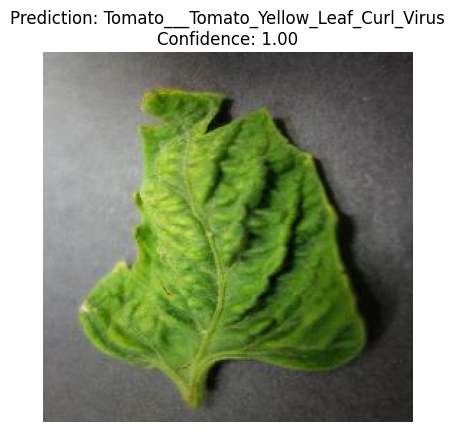

In [31]:
# Load the best fine-tuned model we just saved
best_model = load_model('fine_tuned_model/best_fine_tuned_model.keras')

# --- IMPORTANT: UPDATE THIS PART ---
# The class names list should be the same as before
class_names = sorted(list(train_generator.class_indices.keys()))
# Path to the image you want to test
image_path = 'New Plant Diseases Dataset/test/test/TomatoYellowCurlVirus4.JPG'

# --- Function to load and preprocess the image ---
def preprocess_image(img_path):
    # Load the image and resize it to our model's input size
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    # The model expects a batch of images, so we add a new dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the pixel values just like we did with our training data
    img_array = img_array / 255.0
    return img_array, img

# --- Make a prediction ---
# Preprocess the image
img_array, original_img = preprocess_image(image_path)
# Get the model's prediction
predictions = best_model.predict(img_array)
# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions[0])
# Get the name of the predicted class
predicted_class_name = class_names[predicted_class_index]
# Get the confidence score
confidence = predictions[0][predicted_class_index]

# --- Display the results ---
plt.imshow(original_img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}\nConfidence: {confidence:.2f}")
plt.show()